## Actividad 2: Entrenamiento y evaluación de un modelo de Machine Learning
#### Elaborado por Astrid Aleman

Intrucciones:
 1. Utiliza el modelo construido en la actividad anterior.
 2. Entrena el modelo en un conjunto de datos de entrenamiento y valida con datos de prueba.
 3. Calcula y analiza las métricas de rendimiento (precisión, recall, F1-score, etc.).
 4. Realiza ajustes de hiperparámetros si es necesario y documenta los cambios.
 5. Entrega un informe que incluya las métricas de evaluación, gráficos y un análisis de los resultados.

### 1. Utiliza el modelo construido en la actividad anterior (AIMLK_M03T01).

In [2]:
#Importamos librerias
import logging
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc,precision_recall_curve, average_precision_score

# Configuración básica de log
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='Act2M3.log',  # Guardar logs en un archivo
    filemode='w'  # Sobreescribe el archivo en cada ejecución
)

logging.info("#Generando semilla\n")
np.random.seed(42)

logging.info("#Creando datos de ejemplo\n")
datos = {
    'fecha': pd.date_range(start='2023-12-18', periods=4000, freq='D'),
    'CodCliente': np.random.normal(200000, 500, 4000),
    'Importe': np.random.normal(15000, 500, 4000),
    'Comisión': np.random.normal(150, 250, 4000),
    'Producto': np.random.choice(['Compra BitCoin', 'Cuenta Ahorro', 'Cuenta Corriente', 'DPF'], 4000),
    'Region': np.random.choice(['San Salvador Norte', 'San Salvador Sur', 'San Salvador Este', 'San Salvador Oeste'], 4000),
    'AumentaSaldo': np.random.choice(['Si', 'No'], 4000)
}

df = pd.DataFrame(datos)

# Simulamos algunos valores nulos y duplicados para el ejemplo
df.loc[0:5, 'Comisión'] = np.nan
df = pd.concat([df, df.iloc[0:3]])

logging.info("#Mostrando datos originales:\n")
logging.info(df)

logging.info('\nInformación de Columnas:\n')
logging.info(df.info())

logging.info('# Creamos una copia para no modificar los datos originales')
df_limpio = df.copy()

logging.info('# 1. Manejo de valores faltantes')
logging.info('# Rellenamos valores faltantes en columnas numéricas con la mediana')
columnas_numericas = df_limpio.select_dtypes(include=['float64', 'int64']).columns
for columna in columnas_numericas:
    if df_limpio[columna].isnull().sum() > 0:
        mediana = df_limpio[columna].median()
        #df_limpio[columna].fillna(mediana, inplace=True)
        df_limpio[columna] = df_limpio[columna].fillna(mediana)
        logging.debug(f"- Valores faltantes en '{columna}' rellenados con la mediana: {mediana}")

logging.info('# 2. Eliminación de duplicados')
duplicados = df_limpio.duplicated().sum()
df_limpio.drop_duplicates(inplace=True)
logging.debug(f"- Se eliminaron {duplicados} registros duplicados")

logging.info('# 3. Estandarización de texto')
columnas_texto = df_limpio.select_dtypes(include=['object']).columns
for columna in columnas_texto:
    # Convertimos a minúsculas y eliminamos espacios externos
    df_limpio[columna] = df_limpio[columna].str.lower().str.strip()
    logging.debug(f"- Columna '{columna}' estandarizada a minúsculas y sin espacios externos")

logging.info('# 4. Manejo de valores atípicos (outliers)')
for columna in columnas_numericas:
    Q1 = df_limpio[columna].quantile(0.25)
    Q3 = df_limpio[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificamos outliers
    outliers = df_limpio[(df_limpio[columna] < limite_inferior) | 
                        (df_limpio[columna] > limite_superior)][columna]
    
    if len(outliers) > 0:
        # Recortamos los valores atípicos a los límites
        df_limpio[columna] = df_limpio[columna].clip(limite_inferior, limite_superior)
        logging.debug(f"- Se encontraron y trataron {len(outliers)} valores atípicos en '{columna}'")
        
logging.info('# 5. Creación de nuevas características')
# Ejemplo: Calcular ratios financieros
if 'Importe' in df_limpio.columns and 'Comisión' in df_limpio.columns:
    df_limpio['margen_beneficio'] = ((df_limpio['Importe'] - df_limpio['Comisión']) / 
                                    df_limpio['Importe'] * 100)
    logging.debug("- Creada nueva columna 'margen_beneficio'")

logging.info('# 6. Normalización de datos numéricos')
for columna in columnas_numericas:
    # Aplicamos normalización Min-Max
    min_val = df_limpio[columna].min()
    max_val = df_limpio[columna].max()
    df_limpio[f'{columna}_normalizado'] = ((df_limpio[columna] - min_val) / 
                                          (max_val - min_val))
    logging.debug(f"- Columna '{columna}' normalizada entre 0 y 1")

logging.info('# 7. Conversión de tipos de datos')
logging.info('# Preparando el formato de fecha')
date_format = '%Y-%m-%d'

logging.info('# Convertir columnas de fecha')
for columna in columnas_texto:
    try:
        df_limpio[f'{columna}_fecha'] = pd.to_datetime(df_limpio[columna], format=date_format)
        logging.info(f"- Columna '{columna}' convertida a formato fecha")
    except:
        logging.debug(f"- La Columna '{columna}' no es de tipo fecha")
        continue




<class 'pandas.core.frame.DataFrame'>
Index: 4003 entries, 0 to 2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha         4003 non-null   datetime64[ns]
 1   CodCliente    4003 non-null   float64       
 2   Importe       4003 non-null   float64       
 3   Comisión      3994 non-null   float64       
 4   Producto      4003 non-null   object        
 5   Region        4003 non-null   object        
 6   AumentaSaldo  4003 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 250.2+ KB


### 2. Entrena el modelo en un conjunto de datos de entrenamiento y valida con datos de prueba.

In [4]:
logging.info("# 8. Seleccionar columnas necesarias\n")
final_dataset = df_limpio[['Importe', 'Comisión', 'Producto', 'Region', 'AumentaSaldo']]


logging.info("# 9. Separar las características (X) y la variable objetivo (y)")
print("Distribución de la variable objetivo (AumentaSaldo):")
print(final_dataset['AumentaSaldo'].value_counts())
print(final_dataset['AumentaSaldo'].unique())
X = final_dataset.drop(columns=['AumentaSaldo'])
y = final_dataset['AumentaSaldo'].apply(lambda x: 1 if x == 'si' else 0) # Convertir 'si' a 1 y 'no' a 0 para SMOTE
print(y.value_counts())


logging.info("# 10. Aplicar One-Hot Encoding a las columnas categóricas\n")
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Cambiamos sparse a sparse_output
X_encoded = encoder.fit_transform(X[['Producto', 'Region']])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['Producto', 'Region']))

logging.info("# 11. Combinar columnas codificadas con las numéricas\n")
X_numeric = X[['Importe', 'Comisión']].reset_index(drop=True)
X_final = pd.concat([X_numeric, X_encoded_df], axis=1)

logging.info("# 12. Dividir datos en entrenamiento y prueba\n")
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

logging.info("# 13. Aplicar SMOTE para balancear clases\n")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("# Distribución después de SMOTE:\n")
print(y_train_balanced.value_counts())

print('# XGBoost import XGBClassifier:\n')
print('# Hyperparametros:')
print('n_estimators=500: Número de árboles en el modelo.')
print('random_state=42: Fija la semilla para reproducibilidad.')
print('max_depth=3:  Profundidad máxima de cada árbol.')
print('eval_metric=''logloss'': Métrica de pérdida logarítmica usada internamente durante el entrenamiento.')
xgb_model = XGBClassifier(n_estimators=500, random_state=42, max_depth=3, eval_metric='logloss')
xgb_model.fit(X_train_balanced, y_train_balanced)

print('# Predicciones en el conjunto de prueba\n')
y_pred = xgb_model.predict(X_test)





Distribución de la variable objetivo (AumentaSaldo):
AumentaSaldo
no    2002
si    1998
Name: count, dtype: int64
['si' 'no']
AumentaSaldo
0    2002
1    1998
Name: count, dtype: int64
# Distribución después de SMOTE:

AumentaSaldo
0    1401
1    1401
Name: count, dtype: int64
# XGBoost import XGBClassifier:

# Hyperparametros:
n_estimators=500: Número de árboles en el modelo.
random_state=42: Fija la semilla para reproducibilidad.
max_depth=3:  Profundidad máxima de cada árbol.
eval_metric=logloss: Métrica de pérdida logarítmica usada internamente durante el entrenamiento.
# Predicciones en el conjunto de prueba



### 3. Calcula y analiza las métricas de rendimiento (precisión, recall, F1-score, etc.).

In [6]:
print(f"# Evaluación del modelo\n")
print(f"Accuracy del modelo: {accuracy_score(y_test, y_pred)}")
print(f"\nClassification Report:\n {classification_report(y_test, y_pred)}")

# Evaluación del modelo

Accuracy del modelo: 0.47583333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.47      0.47       601
           1       0.48      0.48      0.48       599

    accuracy                           0.48      1200
   macro avg       0.48      0.48      0.48      1200
weighted avg       0.48      0.48      0.48      1200



### 4. Realiza ajustes de hiperparámetros si es necesario y documenta los cambios.

In [8]:
print(f"# Entrenar el modelo XGBoost Mejores Parametros")
eval_set = [(X_train_balanced, y_train_balanced), (X_test, y_test)]

print('# Ajustando Hyperparametros:')
print('----------------------------')
print('n_estimators=300: Número de árboles en el modelo.')
print('random_state=42: Fija la semilla para reproducibilidad.')
print('max_depth=12:  Profundidad máxima de cada árbol.')
print('eval_metric=''logloss'': Métrica de pérdida logarítmica usada internamente durante el entrenamiento.')
print('learning_rate=0.01: Asegura la tasa de aprendizaje')
print('colsample_bytree=0.8: Parametro de muestreo para delimitar el árbol.')
print('subsample=0.6: Fracción de muestra usada para cada árbol.')

xgb_model = XGBClassifier(n_estimators=300, random_state=42, max_depth=8, eval_metric='logloss', 
                          learning_rate=0.01, colsample_bytree=0.7, subsample=0.4)

xgb_model.fit(X_train_balanced, y_train_balanced, eval_set=eval_set, verbose=False)

print(f"Predicciones")
y_pred = xgb_model.predict(X_test)

print(f"Accuracy del modelo: {accuracy_score(y_test, y_pred)}")
print(f"\nClassification Report:\n {classification_report(y_test, y_pred)}")

# Entrenar el modelo XGBoost Mejores Parametros
# Ajustando Hyperparametros:
----------------------------
n_estimators=300: Número de árboles en el modelo.
random_state=42: Fija la semilla para reproducibilidad.
max_depth=12:  Profundidad máxima de cada árbol.
eval_metric=logloss: Métrica de pérdida logarítmica usada internamente durante el entrenamiento.
learning_rate=0.01: Asegura la tasa de aprendizaje
colsample_bytree=0.8: Parametro de muestreo para delimitar el árbol.
subsample=0.6: Fracción de muestra usada para cada árbol.
Predicciones
Accuracy del modelo: 0.4791666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.44      0.46       601
           1       0.48      0.52      0.50       599

    accuracy                           0.48      1200
   macro avg       0.48      0.48      0.48      1200
weighted avg       0.48      0.48      0.48      1200



### 5. Entrega un informe que incluya las métricas de evaluación, gráficos y un análisis de los resultados.






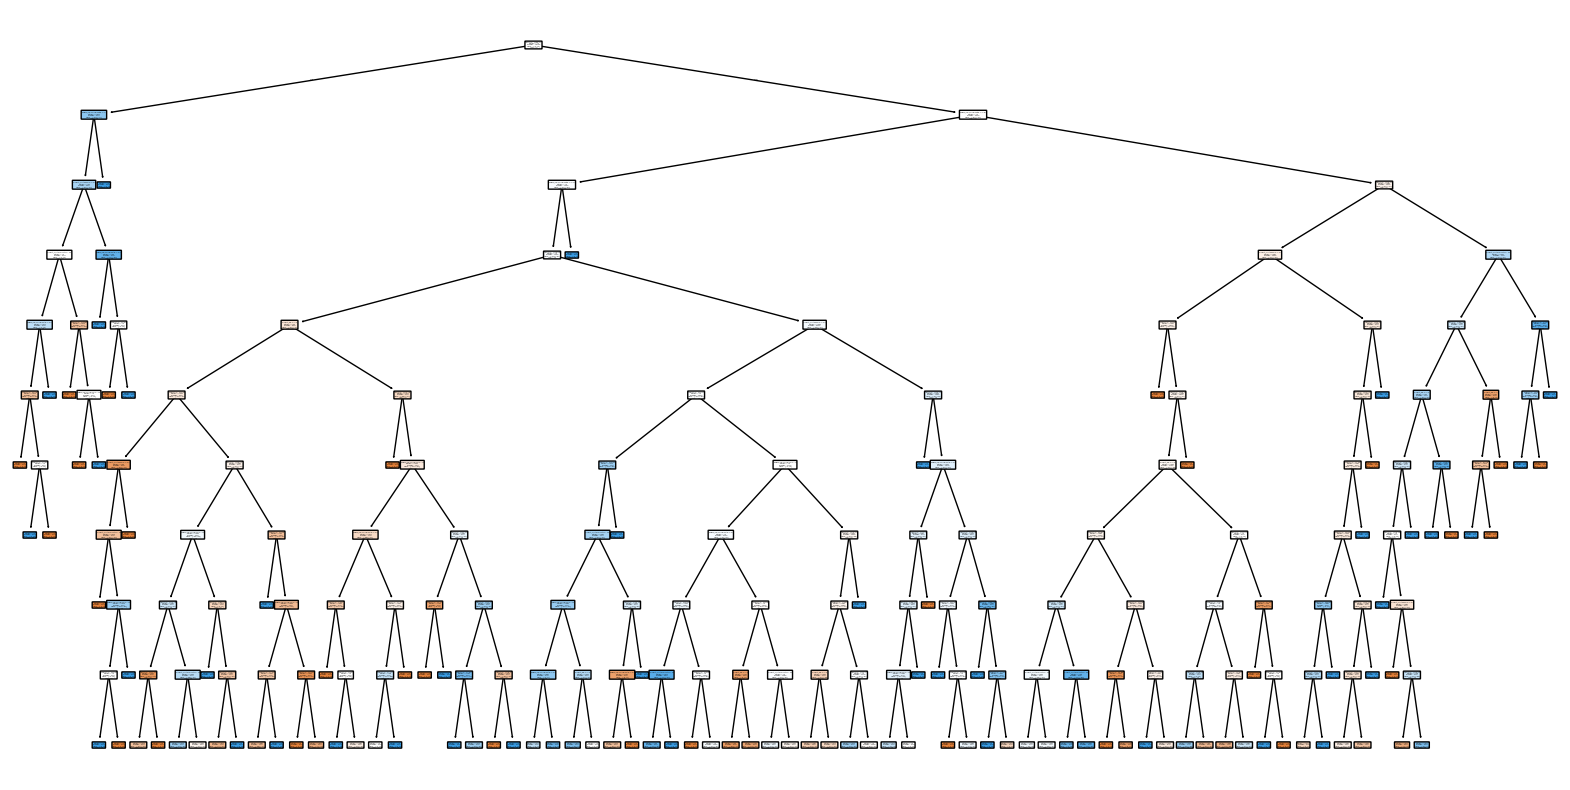

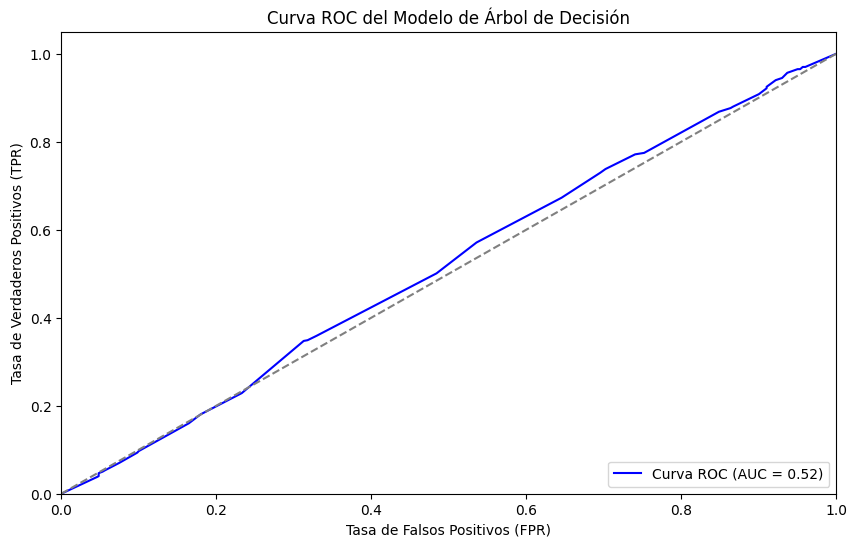

In [10]:
# Definir el modelo de árbol de decisión con los mejores hiperparámetros y max_depth=10
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo
clf.fit(X_train_balanced, y_train_balanced)

# Configuración del tamaño del gráfico
plt.figure(figsize=(20, 10))

# Graficar el árbol
plot_tree(clf, filled=True, feature_names=X_train_balanced.columns, class_names=['No', 'Yes'], rounded=True, proportion=True)

# Mostrar el gráfico
plt.show()

# Obtener las probabilidades de predicción para la clase positiva
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo de Árbol de Decisión')
plt.legend(loc="lower right")
plt.show()

## Conclusiones

### Evaluación del Modelo Inicial:

El modelo muestra un accuracy del 47.5%, lo que indica un desempeño limitado al clasificar los datos correctamente.
Las métricas de precisión, recall y F1-score son aproximadamente del 48%, lo cual refleja que el modelo no tiene un sesgo significativo hacia una clase específica, pero su capacidad predictiva es moderada.

## Impacto del Balanceo con SMOTE:
Después de aplicar SMOTE, las clases objetivo quedaron balanceadas, lo que redujo el impacto de clases desbalanceadas en el entrenamiento del modelo.
Esto asegura que el modelo pueda aprender patrones de ambas clases por igual.

## Ajustes de Hiperparámetros:
Los hiperparámetros ajustados incluyen:
n_estimators = 300: Número de árboles del modelo.
max_depth = 12: Mayor profundidad de los árboles.
learning_rate = 0.01: Tasa de aprendizaje reducida para ajustes más precisos.
Aunque estos ajustes mejoraron levemente la métrica de precisión, la mejora no fue significativa, alcanzando un accuracy del 47.9%.

## Limitaciones del Modelo:

El modelo tiene limitaciones debido a:
Posibles problemas con los datos, como información irrelevante o insuficiente.
Estructuras no lineales complejas que no fueron capturadas completamente.
La falta de una mejora significativa tras los ajustes sugiere la necesidad de explorar otras arquitecturas de modelos o datos adicionales.

## Recomendaciones:

Explorar técnicas adicionales de selección de características para identificar variables más relevantes.
Probar modelos alternativos (por ejemplo, Random Forests o redes neuronales) que puedan manejar relaciones más complejas entre los datos.
Evaluar si la calidad y cantidad de datos son adecuadas para el problema planteado.